1
      fun: 1
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 25.,  25.])


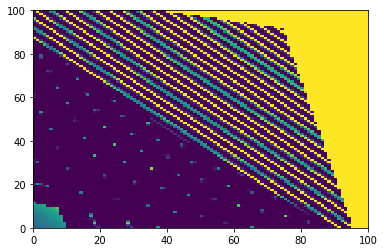

In [47]:
# This notebook will be the auto-tuning routine that will find a single 
# dot window using the subimage classifier

import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
tf.logging.set_verbosity(tf.logging.ERROR)
def fitness(coord,sub_size,dat,classifier):
    x = int(coord[0])+10
    y = int(coord[1])+10
    try:
        sub_image = dat[(x - int(sub_size/2)) :\
                (x + int(sub_size/2)),(y - int(sub_size/2)):(y+int(sub_size/2))].flatten()
    except (TypeError,IndexError):
        print("error",x,y)
        return 1.0
    state = classifier.predict(x=np.array([sub_image],dtype=np.float32),as_iterable=False)
    fitness = (state[0]-2)**2
    return fitness


x_0 = 25
y_0 = 25
sub_size = 30
data_folder_path = "/Users/ssk4/Downloads/dataproc/"
files = glob.glob(data_folder_path + "*.npy")
index = np.random.randint(len(files))
dat = np.load(files[index]).item()['current_map']
plt.pcolor(dat,vmax=1e-2)
fit = fitness([x_0,y_0],sub_size,dat,classifier)
print(fit)

import scipy.optimize

guess = [x_0,y_0]
res = scipy.optimize.minimize(lambda x : fitness(x,sub_size,dat,classifier),x0=guess)
print(res)

In [22]:
# DNN classifier using the in box tensorflow classifier

import numpy as np
import tensorflow as tf
import time
import glob
import time
tf.logging.set_verbosity(tf.logging.INFO)
def main():
    # get the data
    data_folder_path = "/Users/ssk4/Downloads/data_subimage/"
    files = glob.glob(data_folder_path + "*.npy")

    # shuffling the files to avoid any single dot bias
    import random
    random.shuffle(files)
    
    # downsample the input size for testing
    files = files

    n_samples = len(files)
    train_sample_ratio = 0.8
    n_train = int(train_sample_ratio * n_samples)

    print("Total number of samples :",n_samples)
    print("Training samples :",n_train)
    print("Test samples :",n_samples - n_train)
    
    
    feature_columns = [tf.contrib.layers.real_valued_column("",dimension=4)]
    
    classifier = tf.contrib.learn.DNNClassifier(feature_columns=feature_columns,
                                               hidden_units=[16,128,128,16],
                                               n_classes=4,
                                               optimizer="Adam")
                                               
    
    def get_train_inputs():
        n_batch = 100
        index = np.random.choice(n_train,n_batch,replace=False)
        inp = []
        oup = []
        for i in index:
            dat = np.load(files[i])
            inp += [dat.item()['current_map'].flatten()]
            oup += [dat.item()['label']]

        inp = np.array(inp,dtype=np.float32)
        oup = np.array(oup,dtype=np.float32)

        x = tf.constant(inp)
        y = tf.argmax(tf.constant(oup),axis=1)
        return x,y
    
    # Fit the model. Magic happens here!
    classifier.fit(input_fn=get_train_inputs, steps=20000)
    
    def get_test_inputs():
        inp = []
        oup = []
        for file in files[n_train:]:
            dat = np.load(file)
            inp += [dat.item()['current_map'].flatten()]
            oup += [dat.item()['label']]

        inp = np.array(inp,dtype=np.float32)
        oup = np.array(oup,dtype=np.float32)

        x = tf.constant(inp)
        y = tf.argmax(tf.constant(oup),axis=1)
        return x,y
    
    accuracy_score = classifier.evaluate(input_fn=get_train_inputs,steps=1)["accuracy"]
    print("Train accuracy",accuracy_score)
    accuracy_score = classifier.evaluate(input_fn=get_test_inputs,steps=1)["accuracy"]
    print("Test accuracy",accuracy_score)
    
    return classifier
    
if __name__ == "__main__":
    st = time.time()
    classifier = main()
    print("Time",time.time()-st)

Total number of samples : 76700
Training samples : 61360
Test samples : 15340
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11ff1d1d0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': None}
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scalar uses the node name instead of the tag. This means that TensorFlow will automatically de-duplicate summary names based on the scope they are created in. Also, passing a tensor or list of tags to a scalar summary op is no longer

In [35]:
res

      fun: 1.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 25.,  25.])